# MovieLens Exploratory Dataset
**Purpose:** 

This notebook explores the distribution of input movielens datasets and preprocesses it for the RecSys

**Methodology:**

The notebook assumes input from the [MovieLens Dataset](https://grouplens.org/datasets/movielens/). It will explore the dataset using basic statistics and explores properties of hidden clusters. It outputs a processed dataset of the following format: 

**Author:**

Prajna Soni (@prajnasoni)

In [4]:
# Import the libraries we will be using

import os
import numpy as np
import pandas as pd
import math
#import matplotlib.patches as patches
import matplotlib.pylab as plt

from sklearn import metrics
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
#from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import train_test_split
from IPython.display import Image
from sklearn.tree import export_graphviz


%matplotlib inline

In [5]:
# Load MovieLens dataset
#from lenskit.datasets import ML100K
#movielens = ML100K('ml-100k')

links = pd.read_csv("/Users/pvs262/Documents/rec-sys-dynamics/datasets/movielens-small/links.csv") #links to IMDB and themovieDB
movies = pd.read_csv("/Users/pvs262/Documents/rec-sys-dynamics/datasets/movielens-small/movies.csv")
ratings = pd.read_csv("/Users/pvs262/Documents/rec-sys-dynamics/datasets/movielens-small/ratings.csv")
tags = pd.read_csv("/Users/pvs262/Documents/rec-sys-dynamics/datasets/movielens-small/tags.csv")

In [6]:
# Timestamp is the timestamp since January 1, 1970 in seconds
# Reduce dimensionality of time so it starts from earliest time as 0 seconds
min_t = ratings['timestamp'].min()
ratings['timestamp'] = ratings['timestamp']-min_t
tags['timestamp'] = tags['timestamp'] - min_t

# Explore Distribution of Dataset

<AxesSubplot:title={'center':'Distribution of Total Ratings (Count)'}>

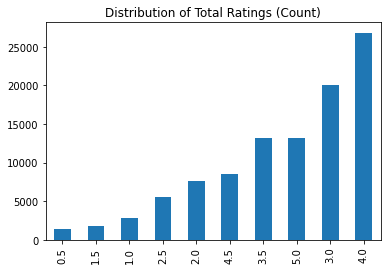

In [7]:
rating_count = ratings['rating'].value_counts()
rating_count = rating_count.sort_values(ascending=True)
rating_count.plot.bar(title='Distribution of Total Ratings (Count)')

(0.0, 5.0)

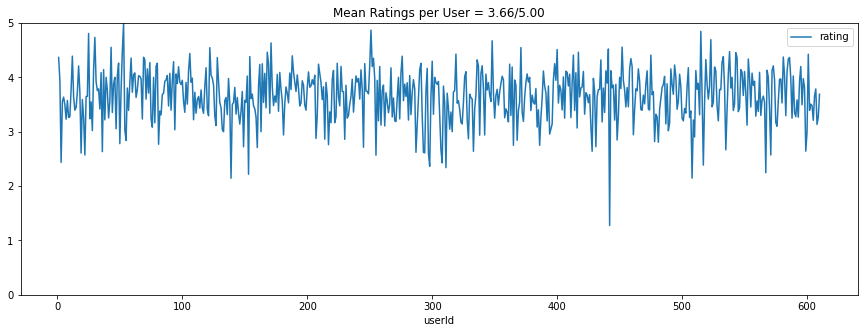

In [8]:
avg_user = ratings.drop(columns = ['movieId','timestamp'], axis = 1)
avg_movie = ratings.drop(columns = ['userId','timestamp'], axis = 1)
avg_user = avg_user.groupby(['userId']).mean()
avg_movie = avg_movie.groupby(['movieId']).mean()
plt = avg_user.plot(y='rating',figsize=(15,5),title='Mean Ratings per User = 3.66/5.00')
plt.set_ylim((0,5))

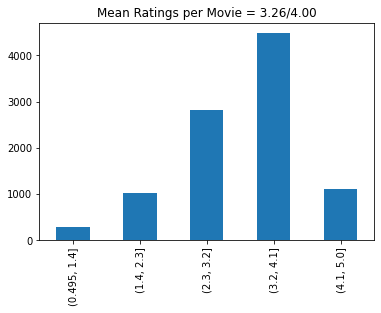

In [9]:
rating_range = [0,1,2,3,4,5]
avg_movie = avg_movie['rating'].value_counts(bins=5, sort=False)
plt = avg_movie.plot.bar(y = 'rating', title = 'Mean Ratings per Movie = 3.26/4.00')

# Identifying Communities/Clusters

In [10]:
# List of all genres: ['(no genres listed)','Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime','Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War','Western']

# Function to get the genre ratings
def get_genre_ratings(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    for genre in genres:        
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)
        
        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)
        
    genre_ratings.columns = column_names
    return genre_ratings

# Function to split movie genres into dummy variables
def dummy_genres(movies):
    genres = movies['genres'].str.split(pat='|') # convert string to list of string
    movies2 = movies.drop(['genres','title'],axis=1)
    movies2 = pd.concat([movies2, genres.str.join('|').str.get_dummies()], axis=1) # concatenate dummy variables df of genres
    return movies2
    

In [11]:
# split genres into binary columns
movies2 = dummy_genres(movies)
# append dummy genre variables to ratings
ratings2 = pd.merge(ratings,movies2,on='movieId')


# K-Means Clustering

In [12]:
# Calculate each user's average rating for each genre based on movies rated
genres = ['(no genres listed)','Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime','Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War','Western']
genre_ratings = get_genre_ratings(ratings, movies, genres, genres)
genre_ratings = genre_ratings.fillna(0)
genre_ratings.head()

/Users/pvs262/Library/Python/3.8/lib/python/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
1,0.0,4.32,4.39,4.69,4.55,4.28,4.36,0.00,4.53,4.30,5.0,3.47,0.00,4.68,4.17,4.31,4.22,4.15,4.50,4.29
2,0.0,3.95,4.17,0.00,0.00,4.00,3.80,4.33,3.88,0.00,0.0,3.00,3.75,0.00,4.00,4.50,3.88,3.70,4.50,3.50
3,0.0,3.57,2.73,0.50,0.50,1.00,0.50,0.00,0.75,3.38,0.0,4.69,0.00,0.50,5.00,0.50,4.20,4.14,0.50,0.00
4,0.0,3.32,3.66,4.00,3.80,3.51,3.81,4.00,3.48,3.68,4.0,4.25,3.00,4.00,3.48,3.38,2.83,3.55,3.57,3.80
5,0.0,3.11,3.25,4.33,4.11,3.47,3.83,0.00,3.80,4.14,0.0,3.00,3.67,4.40,4.00,3.09,2.50,3.56,3.33,3.00


In [13]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
#kmeans.fit(genre_ratings)
predictions = kmeans.fit_predict(genre_ratings)
predictions = pd.DataFrame(predictions, columns = ['cluster'])
predictions.index += 1 # adjust index to match userId
clustered_ratings = pd.concat([genre_ratings, predictions], axis=1)
#clustered_ratings

<AxesSubplot:title={'center':'Distribution of Users in Clusters (Count)'}>

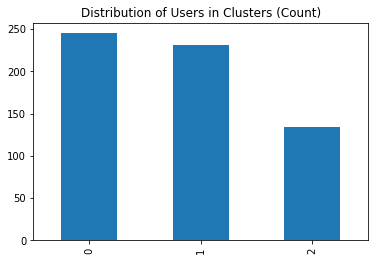

In [14]:
# Examine distribution of clusters 
cluster_count = predictions['cluster'].value_counts()
cluster_count.plot.bar(title='Distribution of Users in Clusters (Count)')

In [15]:
# Assign features and target variable
X = genre_ratings
Y = predictions

In [16]:
# Train a decision tree to understand the definiing features separating the clusters 
# and understand how the entropy changes 

# We split the data into a training (80%) and testing (20%) dataset
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.20, random_state=0, stratify=Y)
#declare decision tree classifier classifiying based on entropy 
KMeans_Tree = DecisionTreeClassifier(max_depth = 3, criterion ='entropy')
#train decision tree classifier on training data
KMeans_Tree.fit(train_X, train_Y)
#get predicted results for given test_X
KMeans_TreePred = KMeans_Tree.predict(test_X)
acc_score = metrics.accuracy_score(test_Y, KMeans_TreePred)
print(acc_score)
metrics.confusion_matrix(test_Y, KMeans_TreePred)

0.8442622950819673


array([[43,  4,  2],
       [ 1, 43,  2],
       [ 7,  3, 17]])

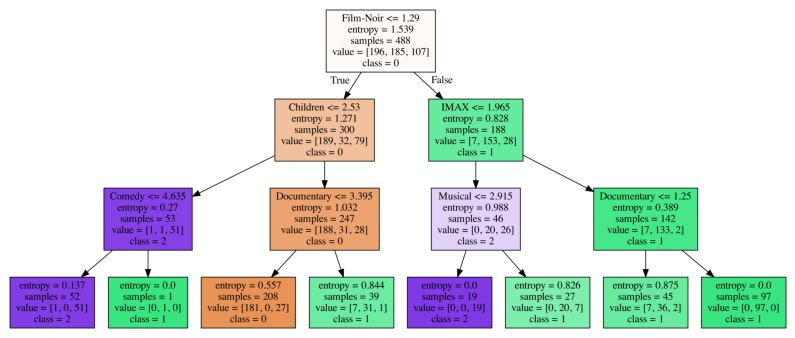

In [18]:
#Let's visualise the tree
tree.export_graphviz(KMeans_Tree, out_file = 'KMeans_Tree.dot', feature_names = X.columns, class_names = ['0','1','2'], filled = True)
# Convert to png
from subprocess import call
call(['dot', '-Tpng', 'KMeans_Tree.dot', '-o', 'KMeans_Tree.png', '-Gdpi=600'])

# Display in python
import matplotlib.pyplot as plt
plt.figure(figsize = (14, 18))
plt.imshow(plt.imread('KMeans_Tree.png'))
plt.axis('off');
plt.show();